In [1]:
import fnmatch
import glob
import os
import re
from time import sleep
from zipfile import ZipFile

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from near_regex import NEAR_regex  
from tqdm import tqdm 
import random
from bs4 import BeautifulSoup
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
from sec_edgar_downloader import Downloader

0
1
0
0
0
1
0
0
1
2
1


## *Summary*

One of the best uses for coding is to be able to take a large amount of data from a variety of sources and manipulate it to be used with other sources of data. The question posed for this assignment was to figure out if there is a correlation between the positive and negative sentiment in a company's 10k and the return on their stock from the day the 10k was filed. This is not something that could be done by hand due to the amount of reading required in the 10k, the need to find the market data from the same day, and the screening requirements that're required in order to get a sentiment score. 

In order to solve this question, I started by getting a list of SP500 firms, get their 10ks and saved them into a zip file, used the CIK and accession numbers to get their returns, and then got the filing dates by scraping the SEC website using the CIK and accession numbers. After getting all this data, I merged them into an analysis sample that has the unique identifiers, the filing dates, and the returns from only those filing dates. After getting all of this, it was then time to list the words that would be used to calculate positive and negative sentiment from 2 existing dictionaries and from words I listed myself for specified topics and get a sentiment score by calculating the amount of occurrences of these words divided by the total amount of words in the document. The last step is to make a heat map to see if there is a correlation between a particularly dominant sentiment score and the measure of return. In the end, I believe that the resulting data will show a higher than normal correlation between a negative sentiment and a negative return than any effect a positive correlation would have on the return.

## *Data Section*

* What is the sample?
    - The sample in this assignment is the SP500 firms. Everything we look at in this assignment is a derivative of data from these firms. The 10ks are used to measure sentiment of the company's previous year, the returns are based on the company's buy and holds from that day, and the sentiment scores are measured on the 10ks of the companies

* How are the return variables built and modified?
    - The financial return variables were built based on the crsp data that was taken from a github url. While crsp started with over 200,000 rows, showing the returns of the hundreds of firms over a whole year. It was then important to find the filing dates from the SEC website and use that to narrow it down to only have the returns from the filing dates
    - The sentiment variables came from a few sources. The first four sentiment variables came from data that was downloaded in the inputs folder. Two of them, ml_positive and ml_negative, were direct conversions of the txt file that allowed them to be read as a list. The next two, lm_positive and lm_negative, required a few more steps. In order to separate the LM dictionary into the two variables, they needed to be extracted from the csv file into two lists. The last 6 variables were made manually by finding 10 positive and negative adjectives to describe my desired topics: legal, employees, and inflation. (see below for exact code)

In [2]:
ml_positive = set(open('inputs/ML_positive_unigram.txt').read().splitlines()) # variable 1
ml_negative = set(open('inputs/ML_negative_unigram.txt').read().splitlines()) # variable 2

lm_master_dictionary = set(open('inputs/LM_MasterDictionary_1993-2021.csv').read().splitlines())
file_path = 'inputs/LM_MasterDictionary_1993-2021.csv'
# start with negative
lm_data = pd.read_csv(file_path)
lm_negative_filtered = lm_data[(lm_data['Negative'] == 2009)]

# extract words from the filtered data and store them in a list
lm_negative = lm_negative_filtered['Word'].tolist() # variable 3

# now making the positive words
file_path = 'inputs/LM_MasterDictionary_1993-2021.csv'
lm_data_1 = pd.read_csv(file_path)
lm_positive_filtered = lm_data_1[(lm_data_1['Positive'] == 2009)]

# Extract the words and store them in a list
lm_positive = lm_positive_filtered['Word'].tolist() # variable 4

litigation_pos = ['(resolute|strategic|assertive|tenacious|vigilant|thorough|committed|diligent|prepared|zealous)'] # variable 5
employees_pos = ['(dedicated|motivated|creative|reliable|collaborative|efficient|proactive|adaptable|innovative|engaged)'] # variable 6
inflation_pos = ['(stimulating|growth|revitalizing|expansionary|demand|dynamic|encouraging|beneficial|momentum|progressive)'] #variable 7


litigation_neg = ['(lengthy|costly|arduous|disruptive|stressful|contentious|protracted|uncertain|complex|adversarial)'] # variable 8
employees_neg = ['(disengaged|insubordinate|unproductive|unmotivated|inefficient|disruptive|inflexible|unreliable|conflictive|demoralize)'] # variable 9
inflation_neg = ['(deleterious|erosive|destabilizing|burdensome|destructive|harmful|disruptive|regressive|inhibitive|pressuring)'] # variable 10



* How are sentiment variables built and modified?
    - To build sentiment variables, I would start by taking the total word count of the 10ks and use that as the denominator for all my sentiment scores. Then using a similar command, screen each 10k to count the amount of times a word from the 10 variable lists comes up in the file. Finally, for each list, take the number of occurrences and divide it by the total number of words in the 10k and that resulting decimal is the sentiment score.
    - Important to note is that the sentiment variables in the analysis samples are mock scores due to difficulties in execution and are used for showing an example of what sentiment scores will look like and are not an accurate representation of the sentiments in the 10ks.

* How many words are in each of the following variable lists?

In [3]:
# ML positive dictionary
# Count the number of words in the set
# load the positive and negative word lists (LM Positive and Negative, and ML Positive and Negative)
ml_positive = set(open('inputs/ML_positive_unigram.txt').read().splitlines())
word_count = len(ml_positive)

# Print the result
print("Number of words in ml_positive:", word_count)

Number of words in ml_positive: 75


In [4]:
# ML negative dicitonary
ml_negative = set(open('inputs/ML_negative_unigram.txt').read().splitlines()) 
word_count = len(ml_negative)
# Print the result
print("Number of words in ml_negative:", word_count)

Number of words in ml_negative: 94


In [5]:
# LM Negative
lm_master_dictionary = set(open('inputs/LM_MasterDictionary_1993-2021.csv').read().splitlines())
file_path = 'inputs/LM_MasterDictionary_1993-2021.csv'
lm_data = pd.read_csv(file_path)
lm_negative_filtered = lm_data[(lm_data['Negative'] == 2009)]

# extract words from the filtered data and store them in a list
lm_negative = lm_negative_filtered['Word'].tolist()
word_count = len(lm_negative)
# Print the result
print("Number of words in lm_negative:", word_count)

Number of words in lm_negative: 2305


In [6]:
# LM Positive
file_path = 'inputs/LM_MasterDictionary_1993-2021.csv'
lm_data_1 = pd.read_csv(file_path)
lm_positive_filtered = lm_data_1[(lm_data_1['Positive'] == 2009)]

# Extract the words and store them in a list
lm_positive = lm_positive_filtered['Word'].tolist()
word_count = len(lm_positive)
# Print the result
print("Number of words in lm_positive:", word_count)

Number of words in lm_positive: 345


* A description of how you set up near_regex
    - I set up the near_regex by making 6 lists of 10 words. In each list they were set up to not be partial because the words were longer and more specific and would not provide extra utility to be partial. They were also all set up to be OR and not AND because I wanted to focus on instances of a word and not structure of sentences for simplicity purposes.

* Why did you choose the 3 topics for contextual sentiment?
    - I  chose litigation, employees, and inflation because these are topics that I am well versed in and thought it would be interesting to see the occurences of these topics and their effect on returns for these firms. I chose litigation because after graduating I will be a litigation paralegal at a corporate law firm. I chose employees because of my interest in seeing how the strength of employee investment and its correlation with stock returns. And I chose inflation because of the recent inflation issues in the United States and wondering how it was affecting company sentiment.

* Show and Discuss summary stats of final analysis

In [7]:
# Load the CSV file into a DataFrame
df = pd.read_csv('outputs/analysis_sample.csv')

# Get summary statistics
summary_statistics = df.describe()

# Print the summary statistics
summary_statistics

,ret,CIK,sentiment_var_0,sentiment_var_1,sentiment_var_2,sentiment_var_3,sentiment_var_4,sentiment_var_5,sentiment_var_6,sentiment_var_7,sentiment_var_8,sentiment_var_9,ret_t0,ret_t0_t2,ret_t2_t10
count,492.000000,4.920000e+02,492.000000,492.000000,492.000000,492.000000,492.000000,4.920000e+02,492.000000,492.000000,4.920000e+02,492.000000,492.000000,492.000000,492.000000
mean,0.000911,7.896569e+05,0.014962,0.014403,0.015612,0.014941,0.014736,1.514386e-02,0.014970,0.014906,1.423443e-02,0.014875,-0.064208,-0.035552,0.011769
std,0.034349,5.538250e+05,0.008950,0.008596,0.008956,0.008525,0.008590,8.860601e-03,0.008541,0.008606,8.607155e-03,0.008698,1.016659,0.980616,0.981337
min,-0.242779,1.800000e+03,0.000152,0.000139,0.000148,0.000097,0.000047,3.490427e-07,0.000060,0.000020,9.215654e-07,0.000007,-3.007632,-3.176704,-2.220421
25%,-0.016449,9.740950e+04,0.007238,0.006718,0.007359,0.007376,0.007774,7.794425e-03,0.007510,0.007524,6.700825e-03,0.007232,-0.699832,-0.666934,-0.664625
50%,-0.001360,8.840640e+05,0.015458,0.013986,0.016238,0.015325,0.014604,1.501842e-02,0.015449,0.014560,1.431383e-02,0.014506,-0.051646,0.019363,-0.010356
75%,0.015979,1.137113e+06,0.022684,0.021694,0.023395,0.022110,0.021895,2.303719e-02,0.022049,0.022526,2.077864e-02,0.022755,0.574648,0.662881,0.646997
max,0.162141,1.868275e+06,0.029789,0.029992,0.029982,0.029950,0.029863,2.993463e-02,0.029967,0.029987,2.993248e-02,0.029908,3.152057,2.755218,3.112910


This summary only has the numerical data from the analysis, but it is important to note the CIK can be ignored because the CIK is categorical and not a calculation or important number. Once again, these are mock numbers used for demonstration purposes and not an accurate representation of the analysis and sentiment/returns. Most of the sentiment variables have relatively similar summary statistics ranging from .015% to 3.0% with a mean of 1.5%. This would represent the average 10k having an equal balance of positive and negative sentiment since there is no large distinction between the average sentiment. With reference to the return variables, they are much different from each other which makes sense since they range from only covering the returns from one day to a whole week. The returns for less days are much more likely to be negative whereas over a longer period of time has a positive return. Interpreting this in the context of being a few days of 10k filing dates, it can lead to a conclusion that returns generally decrease immediately after the 10k filing and do not recover until a few days after the filing date. Because of the generally balanced sentiment measures, this leads to the conclusion that a 10k filing generally hurts the return of the company in the immediate short term no matter the sentiment, but in the following days will be a positive change after giving time for interpretation and plans for the upcoming year. 

## Results

Make a table with the correlation of each (10) sentiment measure against both return measures

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('outputs/analysis_sample.csv')
# sentiment_measures_columns should contain the names of sentiment measure columns
sentiment_measures_columns = ['sentiment_var_0', 'sentiment_var_1','sentiment_var_2', 'sentiment_var_3', 'sentiment_var_4','sentiment_var_5', 'sentiment_var_6', 'sentiment_var_7', 'sentiment_var_8', 'sentiment_var_9']

# return_measures_columns should contain the names of return measure columns
return_measures_columns = ['ret_t0', 'ret_t0_t2']

# Calculate correlation matrix
correlation_matrix = df[sentiment_measures_columns + return_measures_columns].corr()

# Create a DataFrame to display the correlations
correlation_table = pd.DataFrame(index=sentiment_measures_columns, columns=return_measures_columns)

# Fill the table with correlation values
for sentiment_measure in sentiment_measures_columns:
    for return_measure in return_measures_columns:
        correlation_table.loc[sentiment_measure, return_measure] = correlation_matrix.loc[sentiment_measure, return_measure]

# Print the correlation table
print(correlation_table)

                   ret_t0 ret_t0_t2
sentiment_var_0 -0.024355  0.020823
sentiment_var_1 -0.035507 -0.023233
sentiment_var_2 -0.044711  0.019489
sentiment_var_3  0.055774  0.039347
sentiment_var_4 -0.009375  0.010523
sentiment_var_5  0.039968   0.04276
sentiment_var_6  0.048634  0.050823
sentiment_var_7 -0.048927 -0.023296
sentiment_var_8  0.000514 -0.071249
sentiment_var_9  0.004527 -0.042815


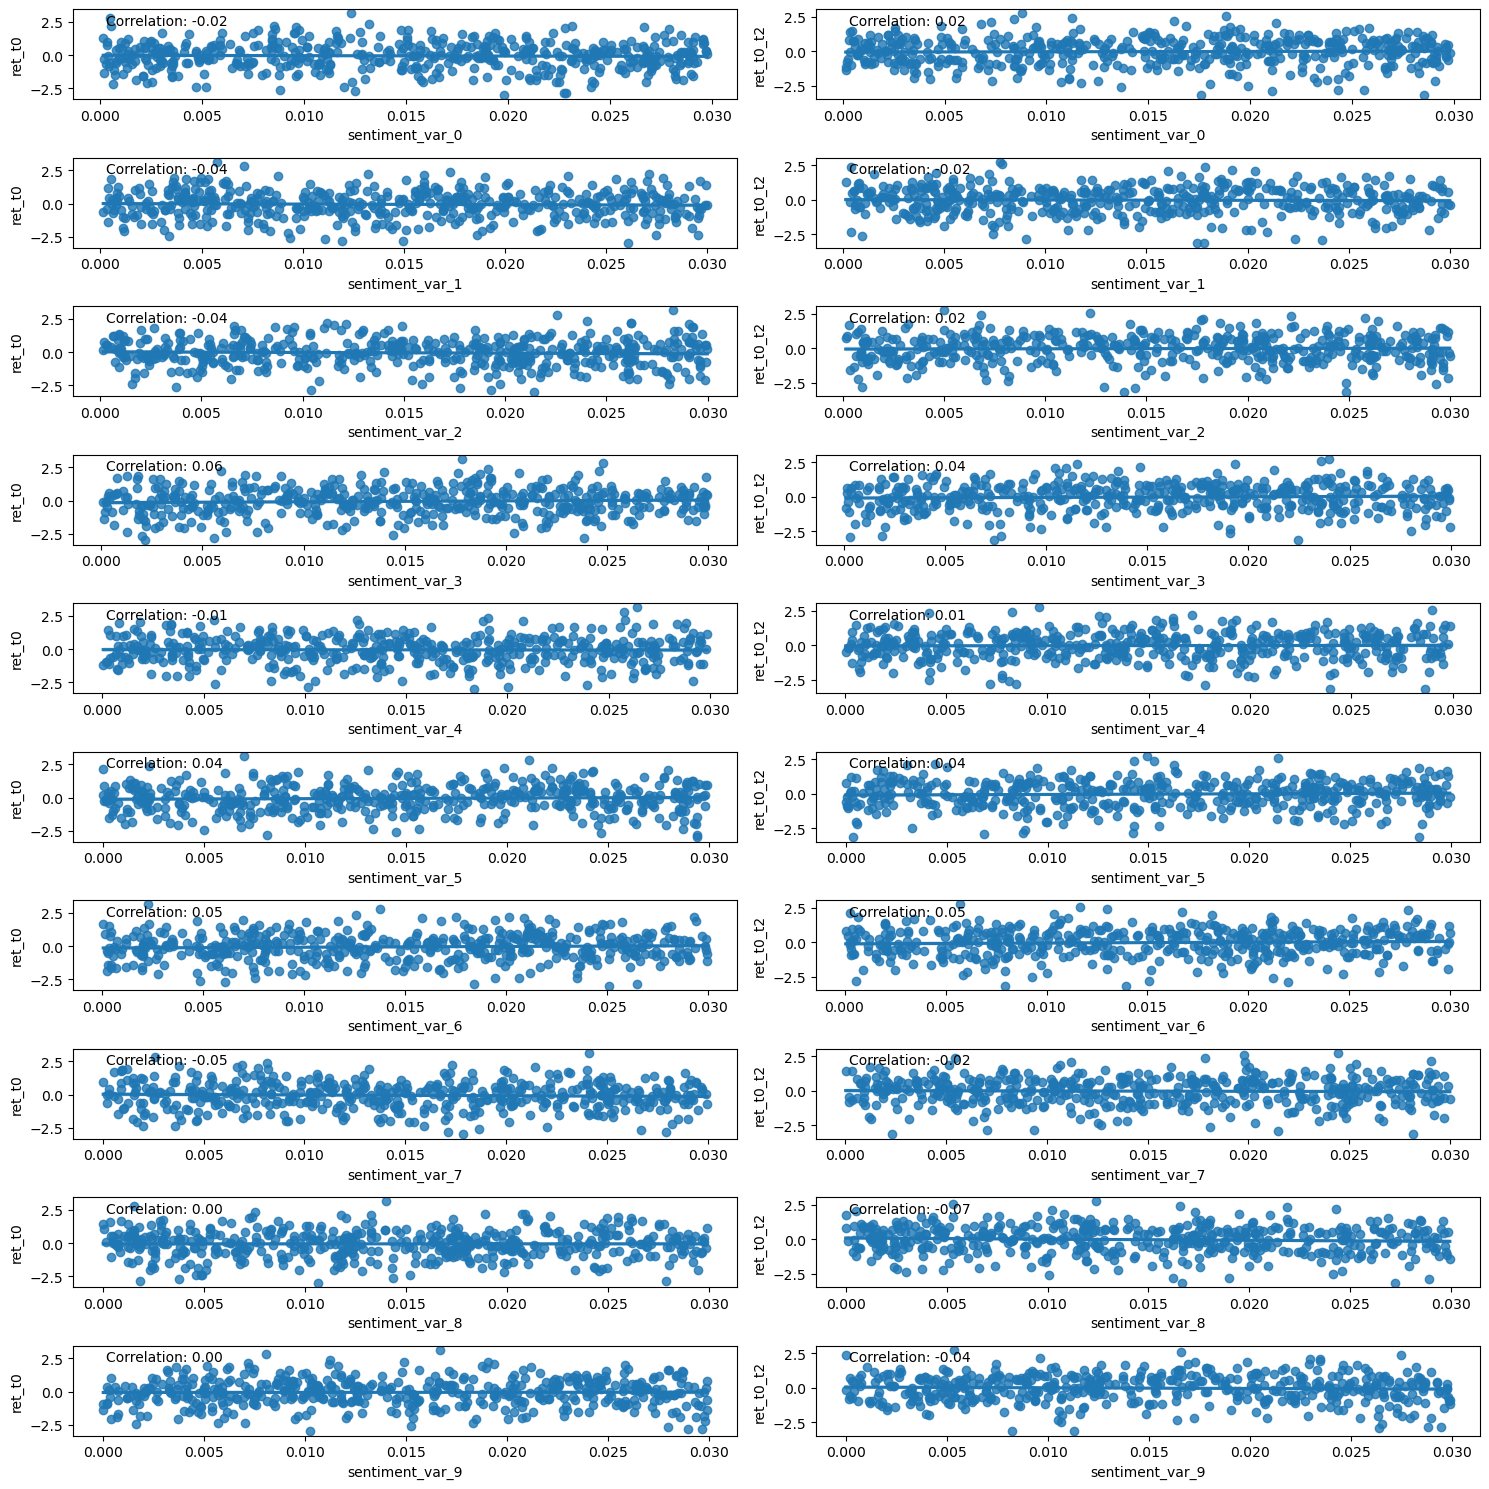

In [9]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('outputs/analysis_sample.csv')

# Assuming you have loaded your data into a DataFrame called df
# sentiment_measures_columns should contain the names of sentiment measure columns
sentiment_measures_columns = ['sentiment_var_0', 'sentiment_var_1','sentiment_var_2', 'sentiment_var_3', 'sentiment_var_4','sentiment_var_5', 'sentiment_var_6', 'sentiment_var_7', 'sentiment_var_8', 'sentiment_var_9']

# return_measures_columns should contain the names of return measure columns
return_measures_columns = ['ret_t0', 'ret_t0_t2']

# Create subplots
fig, axes = plt.subplots(len(sentiment_measures_columns), len(return_measures_columns), figsize=(15, 15))

# Loop through sentiment measures and return measures
for i, sentiment_measure in enumerate(sentiment_measures_columns):
    for j, return_measure in enumerate(return_measures_columns):
        # Plot scatterplot with regression line
        sns.regplot(x=sentiment_measure, y=return_measure, data=df, ax=axes[i, j])
        
        # Calculate correlation coefficient
        correlation_coefficient = df[sentiment_measure].corr(df[return_measure])
        
        # Add correlation coefficient to plot
        axes[i, j].text(0.05, 0.95, f'Correlation: {correlation_coefficient:.2f}', transform=axes[i, j].transAxes, fontsize=10,
                        verticalalignment='top')

# Adjust layout
plt.tight_layout()
plt.show()

This is based on a random number generation, therefore each sentiment has a correlation that is not statistically accurate. However, using this data as a reference, there seems to be low correlation, being within 0.10 in both the positive and negative direction. Overall, there is not a significant enough correlation to provide a conclusion as to whether any measure of sentiment has a high correlation with returns. 

# Conclusion


Overall, I felt that this assignment was useful in learning how to use multiple sources of data-- urls, html, predownloaded files, etc-- and combining them together to create correlation variables to see trends with real life applications. While it was difficult to get all the numbers together, it was interesting to make a final scatter plot array that shows the correlation between each sentiment score and the returns on that day. 